# Why do we choose the exponential function $e^{aq+b}+c$

We opt for the exponential family based on two observations regarding the correlation between 
$\varepsilon$ and $q$:
1. the theoretical result (see Eq.(8)) involves a finite number of logarithmic and exponential functions;
2. empirical findings (see Fig.5) suggest the existence of a convex relationship.

In addition to $e^{aq+b}+c$, we also have assessed two variants and found that increased complexity in the expression leads to marginal improvement in $R^2$. Following Occam's razor principle, we adopt $e^{aq+b}+c$ as our fit function. 

Nevertheless, it is essential to explore superior alternatives for more **substantial** improvements in the future.

In [6]:
import numpy as np
from pynverse import inversefunc
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter("ignore")

from myopacus.accountants.analysis import rdp as privacy_analysis

noise_multiplier = 10.0
steps = 150
rounds = 50
target_delta = 1e-4
client_rates = [0.8, 0.5, 0.2]

# Fit functions
fit_func = {
    "exp1":(lambda x, a, b, c: np.exp(a*x), lambda a, b, c: f"exp({a:.2f}q)"),
    "exp2":(lambda x, a, b, c: np.exp(a*x + b), lambda a, b, c: f"exp({a:.2f}q+{b:.2f})"),
    "exp3":(lambda x, a, b, c: np.exp(a*x + b) + c, lambda a, b, c: f"exp({a:.2f}q+{b:.2f}){c:.2f}"),
    "exp4":(lambda x, a, b, c, d: np.exp(a*x**2 + b*x + c) + d, lambda a, b, c, d: f"exp({a:.2f}$q^2$+{b:.2f}q+{c:.2f}){d:.2f}"),
    "exp5":(lambda x, a, b, c, d, e: np.exp(a*x**3 + b*x**2 + c*x + d) + e, lambda a, b, c, d, e: f"exp({a:.2f}$q^3${b:.2f}$q^2$+{c:.2f}q+{d:.2f}){e:.2f}")
}

# pre-defined rdp order list
orders = privacy_analysis.generate_rdp_orders()

# pre-defined sampling rates
q_examples = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]

q_candidates = np.concatenate([np.arange(0, 1.0, 0.01), np.arange(0, 0.1, 0.001), [1.0]])
q_candidates = np.array(sorted(np.unique(q_candidates)), dtype=np.float32)
q_candidates = q_candidates[q_candidates > 1e-5] # remove all candidates that less than 1e-5

In [7]:
all_examples = []
for _, client_q in enumerate(client_rates):
    examples = []
    for q in q_candidates:
        total_rdp = privacy_analysis.compute_rdp_fed(
            q=q, client_q=client_q,
            noise_multiplier=noise_multiplier,
            steps=steps, 
            rounds=rounds,
            orders=orders
        )
        eps, _ = privacy_analysis.get_privacy_spent(
            orders=orders, rdp=total_rdp, delta=target_delta)
        examples.append(eps)
    all_examples.append(np.array(examples, dtype=np.float32))

In [8]:
all_popts, all_r2 = [], []
keys = ["exp1","exp2","exp3"]

for i, client_q in enumerate(client_rates):
    popts_dict = dict(zip(keys, [0]*len(keys)))
    r2_dict = dict(zip(keys, [0]*len(keys)))
    for key, (func, func_str) in fit_func.items():
        popt, _ = curve_fit(func, q_candidates, all_examples[i])
        r2 = r2_score(func(q_candidates, *popt), all_examples[i])
        popts_dict[key] = popt
        r2_dict[key] = r2
        print(f'The R-Squared value of the best-fit curve {func_str(*popt)} for client_rate = {client_q}:', r2)
    all_popts.append(popts_dict)
    all_r2.append(r2_dict)

The R-Squared value of the best-fit curve exp(4.49q) for client_rate = 0.7: 0.8683486623057557
The R-Squared value of the best-fit curve exp(2.93q+1.42) for client_rate = 0.7: 0.9647578733832012
The R-Squared value of the best-fit curve exp(1.56q+2.91)-18.54 for client_rate = 0.7: 0.9998637640646669
The R-Squared value of the best-fit curve exp(0.23$q^2$+0.94q+3.46)-31.96 for client_rate = 0.7: 0.9998966650201487
The R-Squared value of the best-fit curve exp(0.16$q^3$-0.20$q^2$+1.54q+3.00)-20.30 for client_rate = 0.7: 0.999914522411369
The R-Squared value of the best-fit curve exp(4.40q) for client_rate = 0.6: 0.879137908132527
The R-Squared value of the best-fit curve exp(2.93q+1.33) for client_rate = 0.6: 0.9657832522329833
The R-Squared value of the best-fit curve exp(1.58q+2.80)-16.53 for client_rate = 0.6: 0.9997676585334649
The R-Squared value of the best-fit curve exp(0.23$q^2$+0.94q+3.35)-28.70 for client_rate = 0.6: 0.9998254931115176
The R-Squared value of the best-fit curve 

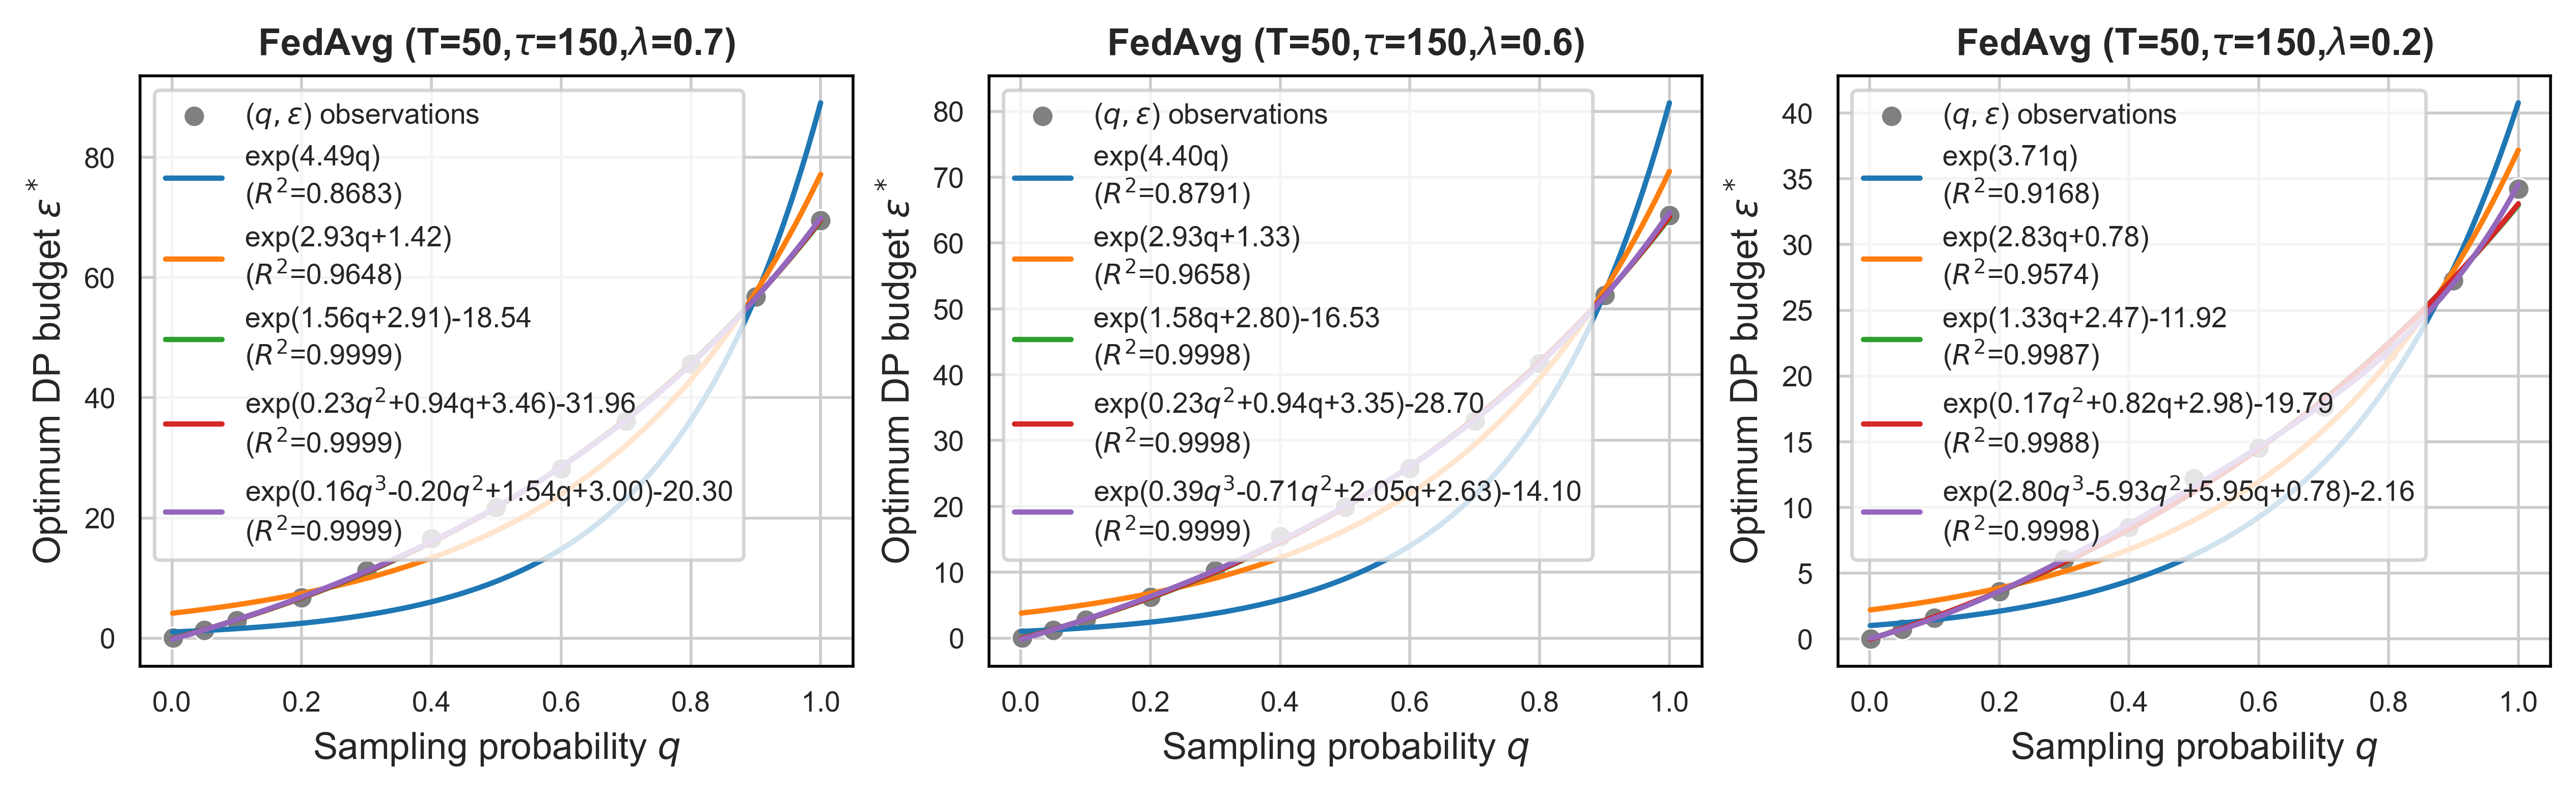

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

# Here we just demo a subset of points (observations) for a more clear illustration
idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189] 

plt.close('all')
fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True, dpi=500)
r"""Comparison between different exponemtial functions. """
for (client_q, examples, popts_dict, r2_dict, ax) in zip(client_rates, all_examples, all_popts, all_r2, axs):
    sns.scatterplot(x=q_candidates[idx], y=examples[idx], label=r'($q,\varepsilon$) observations', color='grey', ax=ax) 
    for key, (func, func_str) in fit_func.items():
        sns.lineplot(x=q_candidates, y=func(q_candidates, *popts_dict[key]), 
                     label=func_str(*popts_dict[key])+f"\n($R^2$={r2_dict[key]:5.4f})", 
                     linestyle='-', ax=ax)

    ax.legend(prop=legend_font)
    ax.set_ylabel(r'Optimum DP budget $\varepsilon^*$', **label_font)
    ax.set_xlabel('Sampling probability $q$', **label_font)
    ax.tick_params(labelsize=8)
    ax.set_title(f'FedAvg (T={rounds},$\\tau$={steps},$\\lambda$={client_q})', **title_font) # 

# plt.savefig('bestfit_exp_func.pdf', dpi=500, bbox_inches='tight')
plt.show()

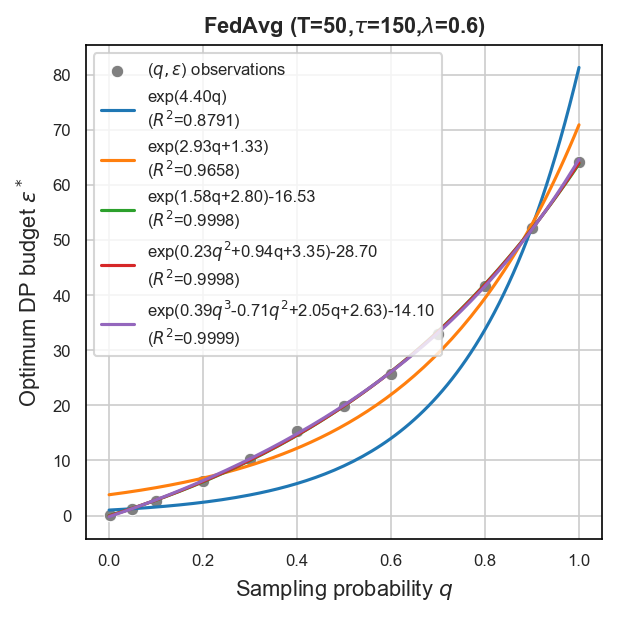

In [10]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True, dpi=150)
r"""Comparison between different exponemtial functions. """
selected_id = 1
sns.scatterplot(x=q_candidates[idx], y=all_examples[selected_id][idx], label=r'($q,\varepsilon$) observations', color='grey', ax=ax) 
for key, (func, func_str) in fit_func.items():
    sns.lineplot(x=q_candidates, y=func(q_candidates, *all_popts[selected_id][key]), 
                 label=func_str(*all_popts[selected_id][key])+f"\n($R^2$={all_r2[selected_id][key]:5.4f})", 
                 linestyle='-', ax=ax)

ax.legend(prop=legend_font)
ax.set_ylabel(r'Optimum DP budget $\varepsilon^*$', **label_font)
ax.set_xlabel(r'Sampling probability $q$', **label_font)
ax.tick_params(labelsize=8)
ax.set_title(f'FedAvg (T={rounds},$\\tau$={steps},$\\lambda$={client_rates[selected_id]})', **title_font) # 

# plt.savefig('bestfit_exp_func.pdf', dpi=500, bbox_inches='tight')
plt.show()